# ライブラリ

In [366]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [367]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() # グラフ描画用
from sklearn.metrics import classification_report

import pandas as pd

from pycm import ConfusionMatrix

import csv

import time
from datetime import datetime
import pytz

0.10.2.post1
2.2.2


# データセットの作成

In [368]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [369]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

### ラベルを含んだデータセット化

In [370]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [371]:
#object層
objLabel = [
    "y-shirt", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "alumi-rack", 
    
    "wood-desk", 
    "wood-shelf", 
    "floor", 
    
    "pla-Case", 
    "pla-Container", 
    "pla-Shelf"
]
objNum= list(range(21))

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [372]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [373]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [374]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [375]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,5.976392,6.822977,4.681773,5.960326,6.270524,5.555223,6.263248,5.569991,4.882263,4.299622,5.108088,4.118065,4.122138,3.967569,4.116028,3.443338,3.565278,4.126280,3.916833,3.730920,3.637775,4.521054,4.199132,3.744049,3.643576,3.375568,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,7.861228,8.265740,4.599344,5.872322,4.592744,3.421162,4.752908,4.337614,6.370227,5.184047,4.849847,4.572804,3.635791,3.783034,3.855815,3.813673,3.487627,3.580301,3.614303,3.740953,3.072972,3.534535,3.042169,3.369778,3.774158,3.591752,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,6.910542,7.356769,5.536133,7.760330,7.464265,5.847036,6.778546,5.678427,4.762488,4.053427,6.746629,5.774625,3.554885,3.849524,4.361592,4.498605,3.461257,3.110470,3.792036,3.168753,3.338651,3.074583,3.769789,3.805089,3.840661,3.640197,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,5.838989,5.840345,5.350352,6.562118,6.123864,6.157910,7.798853,6.637695,6.310810,5.740537,4.283875,5.074739,3.838250,3.857526,3.533555,3.346363,3.364460,3.785767,3.506109,3.593435,4.064413,3.785521,3.418873,3.216819,3.263939,3.749777,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,5.856325,6.333907,5.194138,6.457110,4.888209,4.113900,5.447219,4.366963,3.742785,2.560735,5.125865,4.269754,3.551385,3.413525,3.984665,4.006360,3.462488,4.036200,4.038141,4.260864,3.809444,3.164510,3.141529,2.988619,3.524484,3.013673,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,5.124491,4.392790,1.810222,5.293355,5.642115,3.310058,4.430147,3.386137,1.379967,-0.666656,5.105537,4.917675,4.501484,4.042367,3.783863,3.439915,3.156824,3.767117,3.808424,2.824884,3.257201,3.367261,3.585934,3.489178,3.633662,3.934377,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,6.478649,5.214549,2.118699,5.707488,5.733986,4.036478,4.300111,2.886257,0.640900,-1.331358,4.723089,4.082846,4.431724,3.982713,3.259048,3.752981,3.357792,3.044743,3.499603,3.455720,3.645651,3.302137,3.499025,3.197227,3.511314,3.536093,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,6.095145,5.705307,3.509875,6.584274,7.103280,4.982163,5.235963,3.809655,0.283048,-1.342461,5.148210,5.663366,5.021627,4.321002,3.979507,3.939463,3.860337,3.043857,3.623130,3.147361,3.714255,3.324411,3.435385,3.464588,3.725068,3.644720,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,6.293356,4.448233,1.728071,5.413582,5.679895,3.039169,4.058166,4.360455,2.007196,0.376558,5.098722,4.160040,4.192483,4.390195,3.627769,3.345509,2.960834,3.753970,3.574879,3.692788,3.605611,3.609307,3.550105,3.601384,3.634692,3.832821,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [376]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)

print(Dataset_melspec.shape)
print(type(Dataset_melspec))

# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

(1050, 1, 128, 130)
<class 'numpy.ndarray'>


### データ分割

In [377]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)



In [382]:
# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature_all, eval_feature_all, train_labels_all, eval_labels_all = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.8
)

# val_feature_all, test_feature_all, val_labels_all, test_labels_all = train_test_split(
#     eval_feature_all, eval_labels_all, 
#     stratify=eval_labels_all[:, 0], shuffle=True, random_state=0, train_size=0.2
# )


test_feature_all = eval_feature_all
test_labels_all = eval_labels_all

print(train_labels_all.shape,test_labels_all.shape)


torch.Size([840, 3]) torch.Size([210, 3])


In [383]:
# 学習データにない物体の評価用データセットの作成
def Make_other_dataset(num):

    start = num*trials
    end = (num+1)*trials

    #テストデータの抽出
    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]

    #テストデータ以外でデータセットを作成
    other_feature = torch.cat((Dataset_melspec_tensor[:start,:,:,:],Dataset_melspec_tensor[end:,:,:,:]),dim=0)
    other_labels = torch.cat((Dataset_label_tensor[:start,:],Dataset_label_tensor[end:,:]),dim=0)

    #trainとvalに分割
    train_feature, val_feature, train_labels, val_labels = train_test_split(
        other_feature, other_labels, 
    stratify=other_labels[:, 0], shuffle=True, random_state=0, train_size=0.8
    )   
    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels

# 使用
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

In [384]:
def Alldataset():
    train_feature=train_feature_all
    train_labels=train_labels_all
    val_feature=val_feature_all
    val_labels=val_labels_all
    test_feature=test_feature_all
    test_labels=test_labels_all

    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels


# 評価

## t-SNEで特徴量空間の可視化

In [ ]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [276]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


In [277]:
def Eval_svm_LOOO(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 21 #分割数
    stratifiedkfold = KFold(n_splits=folds, shuffle=False) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)

### object層

               precision    recall  f1-score   support

      y-shirt      0.896     0.860     0.878        50
        jeans      0.833     0.800     0.816        50
   sweatshirt      0.868     0.920     0.893        50
      blanket      0.644     0.760     0.697        50
     bedquilt      0.848     0.780     0.812        50
       pillow      0.809     0.760     0.784        50
     mousepad      0.712     0.740     0.725        50
        chair      1.000     0.960     0.980        50
         sofa      0.933     0.840     0.884        50
   thick-Book      0.741     0.860     0.796        50
    thin-Book      0.792     0.840     0.816        50
    cardboard      0.887     0.940     0.913        50
   metal-desk      0.980     0.980     0.980        50
       laptop      0.961     0.980     0.970        50
   alumi-rack      0.860     0.860     0.860        50
    wood-desk      0.654     0.680     0.667        50
   wood-shelf      0.933     0.840     0.884        50
        f

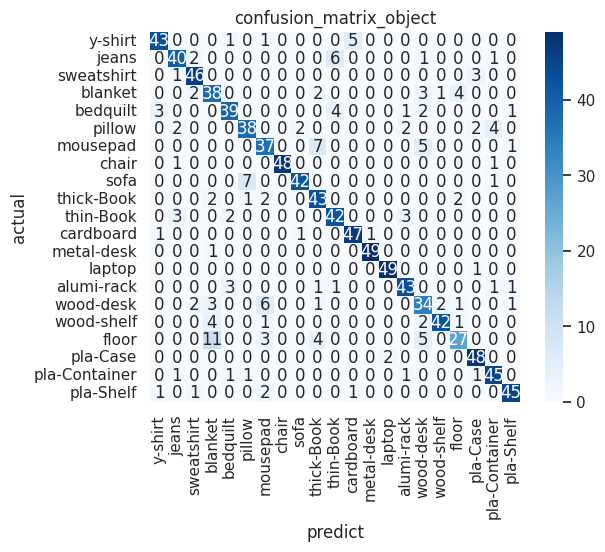

In [278]:
Eval_svm(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000      50.0
   sweatshirt      0.000     0.000     0.000      50.0
      blanket      0.000     0.000     0.000      50.0
     bedquilt      0.000     0.000     0.000      50.0
       pillow      0.000     0.000     0.000      50.0
     mousepad      0.000     0.000     0.000      50.0
        chair      0.000     0.000     0.000      50.0
         sofa      0.000     0.000     0.000      50.0
   thick-Book      0.000     0.000     0.000      50.0
    thin-Book      0.000     0.000     0.000      50.0
    cardboard      0.000     0.000     0.000      50.0
   metal-desk      0.000     0.000     0.000      50.0
       laptop      0.000     0.000     0.000      50.0
   alumi-rack      0.000     0.000     0.000      50.0
    wood-desk      0.000     0.000     0.000      50.0
   wood-shelf      0.000     0.000     0.000      50.0
        f

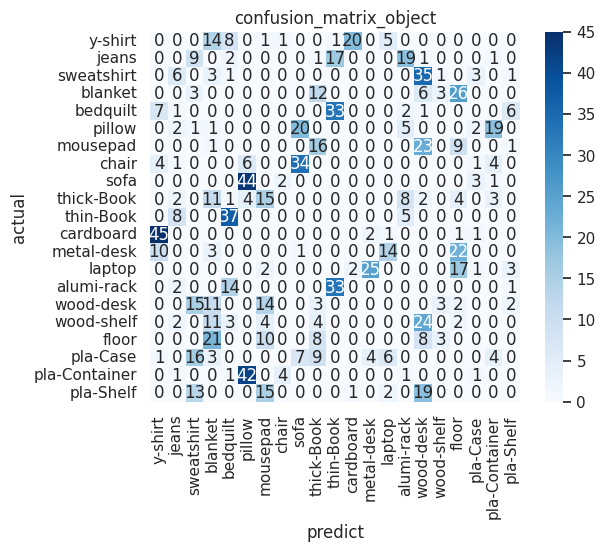

In [279]:
Eval_svm_LOOO(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

In [280]:
print( Dataset_mfcc.obj)

0         y-shirt
1         y-shirt
2         y-shirt
3         y-shirt
4         y-shirt
          ...    
1045    pla-Shelf
1046    pla-Shelf
1047    pla-Shelf
1048    pla-Shelf
1049    pla-Shelf
Name: obj, Length: 1050, dtype: object


### material層

              precision    recall  f1-score   support

    clothing      0.808     0.840     0.824       150
     bedding      0.787     0.887     0.834       150
 memory-foam      0.784     0.653     0.713       150
       paper      0.943     0.880     0.910       150
       metal      0.800     0.853     0.826       150
        wood      0.929     0.960     0.944       150
     plastic      0.910     0.880     0.895       150

    accuracy                          0.850      1050
   macro avg      0.852     0.850     0.849      1050
weighted avg      0.852     0.850     0.849      1050



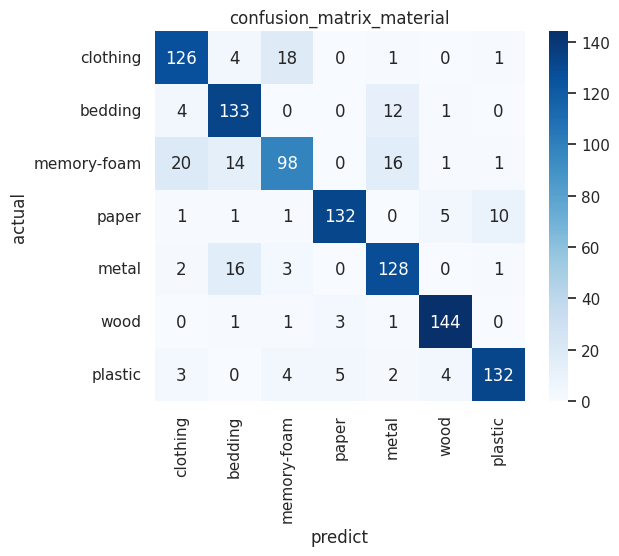

In [281]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

              precision    recall  f1-score   support

    clothing      0.209     0.193     0.201       150
     bedding      0.314     0.467     0.375       150
 memory-foam      0.110     0.113     0.112       150
       paper      0.400     0.333     0.364       150
       metal      0.381     0.500     0.432       150
        wood      0.460     0.267     0.338       150
     plastic      0.520     0.433     0.473       150

    accuracy                          0.330      1050
   macro avg      0.342     0.330     0.328      1050
weighted avg      0.342     0.330     0.328      1050



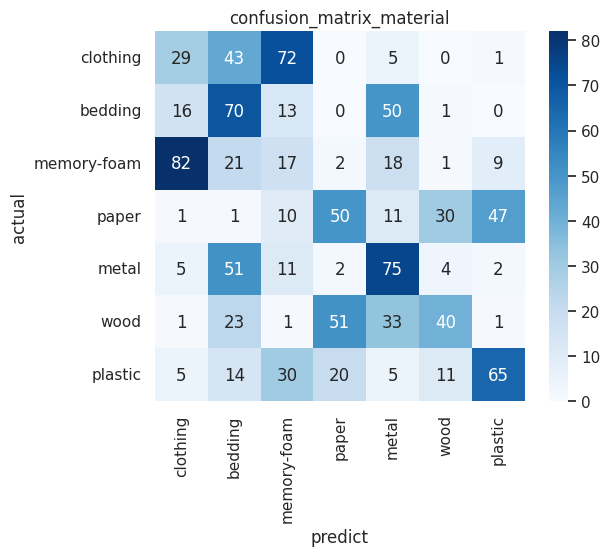

In [282]:
Eval_svm_LOOO(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

              precision    recall  f1-score   support

        soft      0.895     0.897     0.896       600
        hard      0.862     0.860     0.861       450

    accuracy                          0.881      1050
   macro avg      0.879     0.878     0.878      1050
weighted avg      0.881     0.881     0.881      1050



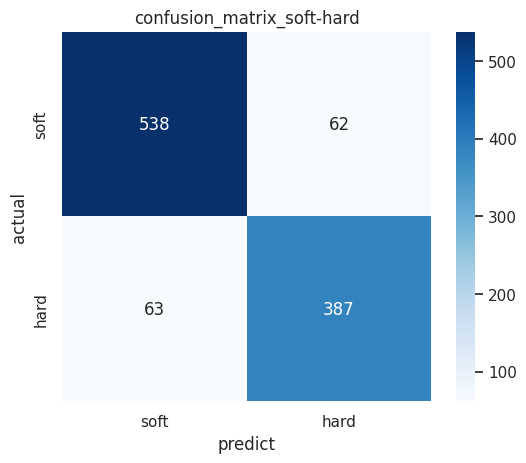

In [283]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

              precision    recall  f1-score   support

        soft      0.836     0.835     0.836       600
        hard      0.780     0.782     0.781       450

    accuracy                          0.812      1050
   macro avg      0.808     0.809     0.809      1050
weighted avg      0.812     0.812     0.812      1050



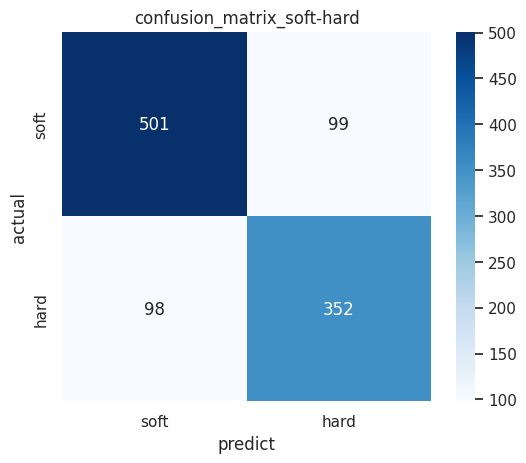

In [284]:
Eval_svm_LOOO(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

### 提案手法適用時の評価

In [349]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc = []
train_label_mfcc = []
eval_data_mfcc = []
eval_label_mfcc = []

train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)


In [350]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.objNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = objLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.objNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)

(420, 21)
420


In [351]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object


平均 decision: 0.5774906009018925
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         6
           1      1.000     1.000     1.000         2
           2      1.000     1.000     1.000         2
           3      1.000     1.000     1.000         5
           4      0.875     1.000     0.933         7
           5      1.000     1.000     1.000        11
           6      1.000     1.000     1.000         5
           7      0.857     1.000     0.923         6
           8      1.000     0.909     0.952        11
           9      1.000     1.000     1.000        11
          10      0.800     1.000     0.889         8
          11      1.000     0.500     0.667         4
          12      1.000     1.000     1.000         7
          13      1.000     0.846     0.917        13
          14      1.000     0.917     0.957        12
          15      1.000     1.000     1.000        16
          16      0.929     1.000     0.963      

In [352]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.matNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = matLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.matNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(420, 7)
420


,clothing,bedding,memory-foam,paper,metal,wood,plastic,decision,prediction,Actual
0,0.001182,0.027871,0.007272,0.000662,0.007784,0.954237,0.000991,0.954237,5,5
1,0.004041,0.142896,0.809251,0.015856,0.014720,0.012815,0.000420,0.809251,2,2
2,0.117623,0.008070,0.149368,0.670227,0.012502,0.032615,0.009594,0.670227,3,3
3,0.186709,0.035856,0.448443,0.229344,0.053502,0.026223,0.019924,0.448443,0,3
4,0.096941,0.010155,0.102019,0.672400,0.056712,0.019541,0.042231,0.672400,3,3
...,...,...,...,...,...,...,...,...,...,...
415,0.647091,0.007467,0.009982,0.324582,0.002542,0.000657,0.007679,0.647091,0,0
416,0.000961,0.008230,0.014657,0.002771,0.390736,0.581098,0.001548,0.581098,5,5
417,0.099218,0.803627,0.033132,0.014855,0.019822,0.020444,0.008901,0.803627,1,1
418,0.036472,0.026670,0.879254,0.010690,0.038796,0.003465,0.004653,0.879254,2,2


In [353]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)


平均 decision: 0.7695275889192149
              precision    recall  f1-score   support

           0      1.000     0.833     0.909        12
           1      0.714     0.833     0.769        12
           2      0.692     1.000     0.818         9
           3      0.875     1.000     0.933        14
           4      1.000     1.000     1.000         6
           5      1.000     0.714     0.833        14
           6      1.000     0.857     0.923        14

    accuracy                          0.877        81
   macro avg      0.897     0.891     0.884        81
weighted avg      0.902     0.877     0.879        81

採用数: 81
採用率: 0.19285714285714287
不採用: (156, 10)


In [354]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = shLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(420, 2)
420


,soft,hard,decision,prediction,Actual
0,0.159332,0.840668,0.840668,1,1
1,0.963539,0.036461,0.963539,0,0
2,0.197348,0.802652,0.802652,1,1
3,0.362554,0.637446,0.637446,1,1
4,0.097082,0.902918,0.902918,1,1
...,...,...,...,...,...
415,0.745264,0.254736,0.745264,0,0
416,0.035956,0.964044,0.964044,1,1
417,0.995630,0.004370,0.995630,0,0
418,0.815011,0.184989,0.815011,0,0


In [355]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
print(classification_report(df['Actual'], df['prediction'],digits=3))

Up_softhard = df[df['decision'] >= average_decision_softhard]


print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)


平均 decision: 0.9082699757751251
              precision    recall  f1-score   support

           0      0.890     0.707     0.788        92
           1      0.675     0.875     0.762        64

    accuracy                          0.776       156
   macro avg      0.783     0.791     0.775       156
weighted avg      0.802     0.776     0.777       156

              precision    recall  f1-score   support

           0      0.962     0.926     0.943        27
           1      0.949     0.974     0.961        38

    accuracy                          0.954        65
   macro avg      0.955     0.950     0.952        65
weighted avg      0.954     0.954     0.954        65

採用数: 65
採用率: 0.15476190476190477
不採用: (91, 5)


In [356]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = shLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(420, 2)
420


,soft,hard,decision,prediction,Actual
0,0.159332,0.840668,0.840668,1,1
1,0.963539,0.036461,0.963539,0,0
2,0.197348,0.802652,0.802652,1,1
3,0.362554,0.637446,0.637446,1,1
4,0.097082,0.902918,0.902918,1,1
...,...,...,...,...,...
415,0.745264,0.254736,0.745264,0,0
416,0.035956,0.964044,0.964044,1,1
417,0.995630,0.004370,0.995630,0,0
418,0.815011,0.184989,0.815011,0,0


In [357]:

df = df.iloc[Down_softhard.index]


print(classification_report(df['Actual'], df['prediction'],digits=3))

              precision    recall  f1-score   support

           0      0.851     0.615     0.714        65
           1      0.432     0.731     0.543        26

    accuracy                          0.648        91
   macro avg      0.641     0.673     0.629        91
weighted avg      0.731     0.648     0.665        91



## CNNでの評価

In [244]:
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

### モデルの保存関数

In [245]:
def Time():
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')
    # 現在の日本時間を取得
    now = datetime.now(jst)
    # 時刻を指定された形式の文字列に変換
    time = now.strftime("%Y%m%d%H%M")

    return time

In [246]:
def SaveModel(model,modelname):
    time = Time()
    model_path = 'data/models_saved/'+time+"_"+modelname+'.pth'
    torch.save(model, model_path)

# #読み込み用
# model_path = 'data/models_saved/202406302329_shModel_2.pth'
# xModel = torch.load(model_path)

### 評価関数

In [247]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN(data_loader,device,num_label,num_trial):
    with torch.no_grad():
        if num_label == 0:
            model = shModel_trained
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            model = matModel_trained
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            model = objModel_trained
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            print(y[0].shape)
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "confusion_matrix_"+model_name
        plt.title(title)
        plt.xlabel('predict')
        plt.ylabel('actual')
        plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

In [248]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN_trained(data_loader,device,num_label,num_trial,model):
    with torch.no_grad():
        if num_label == 0:
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "confusion_matrix_"+model_name
        plt.title(title)
        plt.xlabel('predict')
        plt.ylabel('actual')
        plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

### soft-hard 1

In [249]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [251]:
# モデルのインポート・構築

from models.dymn.model import get_model as get_dymn
shModel = get_dymn(pretrained_name="dymn10_as")

#パラメータを固定
for param in shModel.parameters():
    param.requires_grad = True

#classifierのネットワーク構造を変更・パラメータの更新を許可
shModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
)
print(shModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [ ]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = shModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.1) and epoch<max_epoch:
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_1'    
shModel_trained = net1
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,0,1)

print(report)


In [ ]:
print(confidences)

### material 1

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [252]:
# モデルのインポート・構築

matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [ ]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_1'    
matModel_trained = net2
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,1,1)

print(report)



### object 1

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [253]:
# モデルのインポート・構築

objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_grad = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [ ]:
# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_1'    
objModel_trained = net3
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,2,1)

print(report)


### soft-hard 2

In [ ]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [ ]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_grad = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
    nn.Softmax(dim=1)
)
print(shModel_2)

In [ ]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_2'    
shModel_trained = net4
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , shConfidences= EvalCNN(test_loader,device,0,2)

print(report)


### material 2

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
matModel_2 = shModel_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_grad = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=88, out_features=7, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)
print(matModel_2)

In [ ]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
min_epoch = 100
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.2) and epoch<max_epoch :
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_2'    
matModel_trained = net5
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, matConfidences = EvalCNN(test_loader,device,1,2)

print(report)



### object 2

In [ ]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

In [ ]:
objModel_2 = matModel_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad =  True 

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)

print(objModel_2)


In [ ]:
# エポックの数
max_epoch = 500
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_2'    
objModel_trained = net6
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , objConfidences= EvalCNN(test_loader,device,2,2)

print(report)


## DPSWS 評価

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

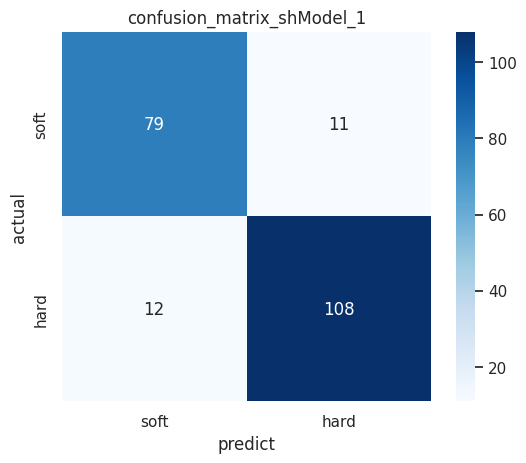

In [385]:
model_path = 'data/models_saved/202406302320_shModel_1.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,1,shModel_eval)
print(shReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

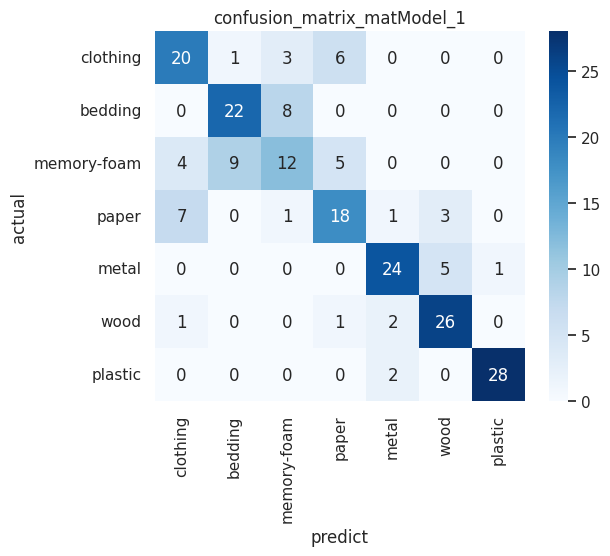

In [386]:
model_path = 'data/models_saved/202406302324_matModel_1.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,1,matModel_eval)
print(matReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

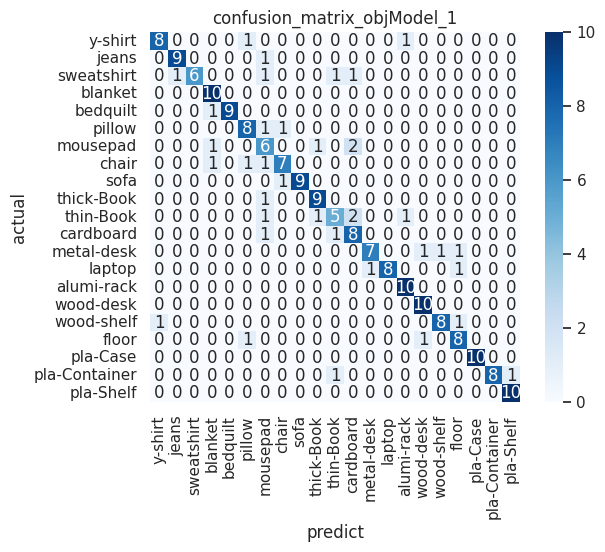

In [387]:
model_path = 'data/models_saved/202406302328_objModel_1.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)

#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,1,objModel_eval)
print(objReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

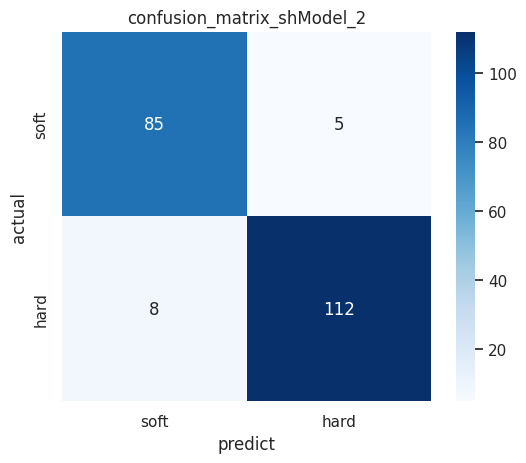

In [388]:
model_path = 'data/models_saved/202406302329_shModel_2.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,2,shModel_eval)
print(shReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

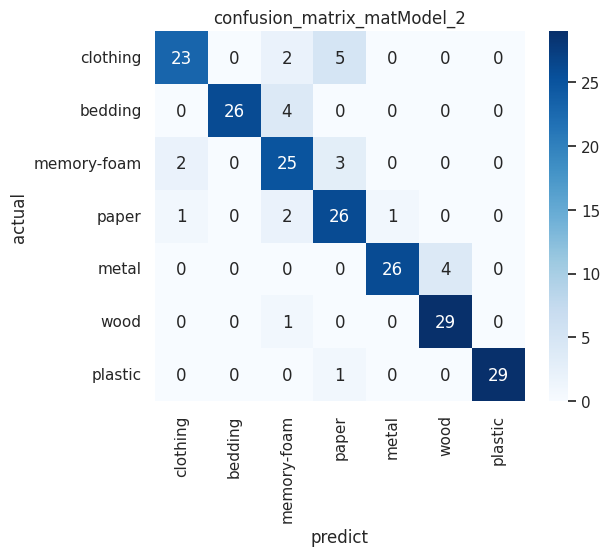

In [389]:
model_path = 'data/models_saved/202406302329_matModel_2.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,2,matModel_eval)
print(matReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

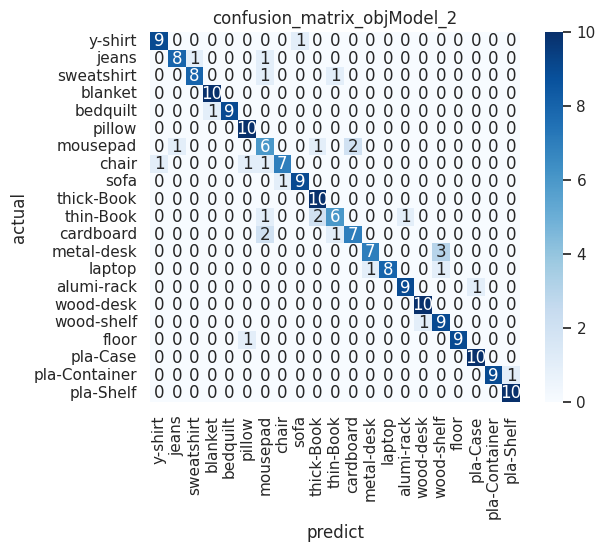

In [390]:
model_path = 'data/models_saved/202406302343_objModel_2.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)
print(objReport)

### 提案手法適用時の評価

In [391]:
print(shConfidences[0])
# print(matConfidences)
# print(objConfidences)

[-1.7104683  1.8130108]


In [392]:
def Hiera_report(confidences,label,preds,actuals):
    array = np.array(confidences)
    print(array.shape)
    # 行ごとにSoftmax関数を適用
    exp_array = np.exp(array)
    softmax_array = np.round((exp_array / np.sum(exp_array, axis=1, keepdims=True)),3)

    print(softmax_array)

    df = pd.DataFrame(softmax_array,columns = label)
    # df["decision"] = np.max(Dec, axis=1)
    df["prediction"] = np.array(preds)
    df['Actual'] = np.array(actuals)
    df["decision"] = np.max(softmax_array, axis=1)
    pd.set_option('display.max_rows',100)
    pd.set_option('display.max_columns',None)


    len_df = len(df.index)

    return df , len_df

In [393]:
df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
up_data = df[df['decision'] >= average_decision_object]


print(classification_report(up_data['Actual'], up_data['prediction'],digits=3))

print("採用数:", len(up_data.index))
print("採用率:", len(up_data.index)/len_df)
# 閾値未満を抽出しDFを作成
down_data = df[df['decision'] < average_decision_object]

print("不採用数:",down_data.shape[0])
    

(210, 21)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
平均 decision: 0.9955555
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         9
           1      1.000     1.000     1.000         8
           2      1.000     1.000     1.000         6
           3      0.909     1.000     0.952        10
           4      1.000     0.900     0.947        10
           5      1.000     1.000     1.000         9
           6      1.000     0.714     0.833         7
           7      0.875     1.000     0.933         7
           8      1.000     0.900     0.947        10
           9      0.909     1.000     0.952        10
          10      0.833     0.833     0.833         6
          11      0.875     0.875     0.875         8
          12      1.000     1.000     1.000         7
          13      1.000     1.000     1.000         8


In [394]:
print(matLabel)

['clothing', 'bedding', 'memory-foam', 'paper', 'metal', 'wood', 'plastic']


In [395]:
df,len_df = Hiera_report(matConfidences,matLabel,matPreds,matActuals)

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[down_data.index]

Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape[0])


(210, 7)
[[0.007 0.007 0.01  ... 0.011 0.941 0.005]
 [0.003 0.985 0.007 ... 0.001 0.001 0.001]
 [0.005 0.004 0.007 ... 0.016 0.955 0.005]
 ...
 [0.005 0.981 0.006 ... 0.002 0.001 0.002]
 [0.717 0.149 0.048 ... 0.021 0.019 0.026]
 [0.003 0.005 0.003 ... 0.013 0.004 0.968]]
平均 decision: 0.8606957
              precision    recall  f1-score   support

           1      0.000     0.000     0.000         1
           2      0.500     1.000     0.667         1
           3      1.000     1.000     1.000         4
           4      0.000     0.000     0.000         1
           5      0.667     1.000     0.800         2

    accuracy                          0.778         9
   macro avg      0.433     0.600     0.493         9
weighted avg      0.648     0.778     0.696         9

採用数: 9
採用率: 0.04285714285714286
不採用: 24


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [396]:
df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
Up_softhard = df[df['decision'] >= average_decision_softhard]


print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape[0])


(210, 2)
[[0.029 0.971]
 [1.    0.   ]
 [0.005 0.995]
 [0.869 0.131]
 [0.005 0.995]
 [0.006 0.994]
 [0.005 0.995]
 [0.004 0.996]
 [0.997 0.003]
 [0.005 0.995]
 [0.009 0.991]
 [0.005 0.995]
 [0.004 0.996]
 [0.004 0.996]
 [0.006 0.994]
 [0.008 0.992]
 [0.004 0.996]
 [0.004 0.996]
 [0.986 0.014]
 [0.01  0.99 ]
 [1.    0.   ]
 [0.992 0.008]
 [0.011 0.989]
 [0.011 0.989]
 [0.007 0.993]
 [0.997 0.003]
 [0.984 0.016]
 [0.388 0.612]
 [0.004 0.996]
 [0.999 0.001]
 [0.007 0.993]
 [0.009 0.991]
 [0.006 0.994]
 [0.999 0.001]
 [0.986 0.014]
 [0.998 0.002]
 [1.    0.   ]
 [0.966 0.034]
 [1.    0.   ]
 [0.01  0.99 ]
 [0.006 0.994]
 [0.004 0.996]
 [0.99  0.01 ]
 [0.998 0.002]
 [0.999 0.001]
 [0.015 0.985]
 [0.008 0.992]
 [0.004 0.996]
 [0.993 0.007]
 [0.006 0.994]
 [1.    0.   ]
 [1.    0.   ]
 [0.993 0.007]
 [0.969 0.031]
 [0.997 0.003]
 [0.053 0.947]
 [0.995 0.005]
 [0.006 0.994]
 [0.005 0.995]
 [1.    0.   ]
 [0.012 0.988]
 [0.005 0.995]
 [0.005 0.995]
 [0.004 0.996]
 [0.007 0.993]
 [0.006 0.994]
 

In [397]:
df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成


Down_material_sh = df.iloc[Down_material.index]


print(classification_report(Down_material_sh['Actual'], Down_material_sh['prediction'],digits=3))

df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)


Down_all = df.iloc[Down_softhard.index]


print(classification_report(Down_all['Actual'], Down_all['prediction'],digits=3))


(210, 2)
[[0.029 0.971]
 [1.    0.   ]
 [0.005 0.995]
 [0.869 0.131]
 [0.005 0.995]
 [0.006 0.994]
 [0.005 0.995]
 [0.004 0.996]
 [0.997 0.003]
 [0.005 0.995]
 [0.009 0.991]
 [0.005 0.995]
 [0.004 0.996]
 [0.004 0.996]
 [0.006 0.994]
 [0.008 0.992]
 [0.004 0.996]
 [0.004 0.996]
 [0.986 0.014]
 [0.01  0.99 ]
 [1.    0.   ]
 [0.992 0.008]
 [0.011 0.989]
 [0.011 0.989]
 [0.007 0.993]
 [0.997 0.003]
 [0.984 0.016]
 [0.388 0.612]
 [0.004 0.996]
 [0.999 0.001]
 [0.007 0.993]
 [0.009 0.991]
 [0.006 0.994]
 [0.999 0.001]
 [0.986 0.014]
 [0.998 0.002]
 [1.    0.   ]
 [0.966 0.034]
 [1.    0.   ]
 [0.01  0.99 ]
 [0.006 0.994]
 [0.004 0.996]
 [0.99  0.01 ]
 [0.998 0.002]
 [0.999 0.001]
 [0.015 0.985]
 [0.008 0.992]
 [0.004 0.996]
 [0.993 0.007]
 [0.006 0.994]
 [1.    0.   ]
 [1.    0.   ]
 [0.993 0.007]
 [0.969 0.031]
 [0.997 0.003]
 [0.053 0.947]
 [0.995 0.005]
 [0.006 0.994]
 [0.005 0.995]
 [1.    0.   ]
 [0.012 0.988]
 [0.005 0.995]
 [0.005 0.995]
 [0.004 0.996]
 [0.007 0.993]
 [0.006 0.994]
 